In [1]:
!pip install --quiet scvi-colab
!pip install --quiet scib-metrics
!pip install --quiet harmonypy
!pip install  --quiet louvain
from scvi_colab import install

install()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [2]:
import scanpy as sc
import scvi
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np
from collections import Counter

In [3]:
!gdown 1QiikxmNxNlHeVpFqicw-Ll72rhZd9Jej

Downloading...
From (original): https://drive.google.com/uc?id=1QiikxmNxNlHeVpFqicw-Ll72rhZd9Jej
From (redirected): https://drive.google.com/uc?id=1QiikxmNxNlHeVpFqicw-Ll72rhZd9Jej&confirm=t&uuid=271ab1c5-0635-4f78-9de8-9c4a662fc118
To: /content/hvg.h5ad
100% 338M/338M [00:09<00:00, 35.9MB/s]


In [4]:
adata = sc.read("hvg.h5ad")
adata

AnnData object with n_obs × n_vars = 24542 × 3000
    obs: 'pool', 'donor', 'treatment', 'donor_treatment'
    var: 'gene'

In [ ]:
adata.obs_keys()
adata.obs['batch'] = adata.obs['donor'].astype(str) + '_' + adata.obs['pool'].astype(str)

In [ ]:
adata.obs['batch'].head()

,batch
P1_AAACGAAAGTACGTCT-1,donor2_pool1
P1_AAACGAATCATGTCTT-1,donor2_pool1
P1_AAACGAATCCGGCAAC-1,donor2_pool1
P1_AAACGAATCGGCTGGT-1,donor2_pool1
P1_AAACGAATCTTGGTCC-1,donor2_pool1


In [ ]:
scvi.model.SCVI.setup_anndata(adata, batch_key="donor", labels_key="treatment", categorical_covariate_keys=["pool"])

In [ ]:
model_gene = scvi.model.SCVI(adata, n_layers=5, n_latent=50, gene_likelihood="zinb", dispersion="gene")
model_gene.train(max_epochs=150, early_stopping=True)
latent_gene = model_gene.get_latent_representation()  # shape: (cells, latent_dim)

latent_df = pd.DataFrame(latent_gene, index=adata.obs_names)
latent_df.to_csv("latent_embedding_gene.csv")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/150 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


In [ ]:
model_treatment = scvi.model.SCVI(adata, n_layers=5, n_latent=50, gene_likelihood="zinb", dispersion="gene-label")
model_treatment.train(max_epochs=150, early_stopping=True)
latent_labels = model_treatment.get_latent_representation()

latent_df = pd.DataFrame(latent_labels, index=adata.obs_names)
latent_df.to_csv("latent_embedding_treatment.csv")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/150 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


In [ ]:
adata.obsm["scvi_gene"] = latent_gene
sc.pp.neighbors(adata, use_rep="scvi_gene", key_added="gene_neighbors")
sc.tl.umap(adata, neighbors_key="gene_neighbors", key_added="gene_umap")

resolutions = [0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9, 0.95]

# Store metrics
metrics = {
    'resolution': [],
    'n_clusters': [],
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
}

for res in resolutions:
    key = f'gene_leiden_{res:.2f}'
    sc.tl.leiden(adata, neighbors_key="gene_neighbors", resolution=res, key_added=key)

    labels = adata.obs[key].astype(int)
    X = adata.obsm['scvi_gene']

    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)

    metrics['resolution'].append(res)
    metrics['n_clusters'].append(len(set(labels)))
    metrics['silhouette'].append(sil)
    metrics['calinski_harabasz'].append(ch)
    metrics['davies_bouldin'].append(db)

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("metrics_gene.csv")
metrics_df

,resolution,n_clusters,silhouette,calinski_harabasz,davies_bouldin
0,0.10,3,0.170774,4675.334961,1.869182
1,0.15,6,0.140587,3376.850830,1.467581
2,0.20,7,0.101454,3201.687988,1.501011
3,0.25,8,0.131664,3171.096680,1.518040
4,0.30,11,0.042009,2715.874512,1.557845
5,0.35,13,0.057448,2528.456299,1.490393
6,0.40,14,0.069380,2555.140625,1.468638
7,0.45,17,0.073308,2403.061523,1.584539
8,0.50,17,0.082741,2471.006592,1.523837


In [5]:
def label_imbalance(cluster_labels, batch_labels, mode="mean", epsilon=1e-8):
    df = pd.concat([cluster_labels, batch_labels], axis=1)
    df.columns = ['cluster', 'batch']

    global_batch_distribution = df['batch'].value_counts(normalize=True).sort_index()

    kl_scores = []

    for cluster, cluster_df in df.groupby('cluster'):
        cluster_batch_distribution = cluster_df['batch'].value_counts(normalize=True).sort_index()

        p = cluster_batch_distribution + epsilon
        q = global_batch_distribution + epsilon
        kl = np.sum(p * np.log(p / q))
        kl_scores.append(kl)

    if mode == "mean":
        return round(np.mean(kl_scores),3)
    elif mode == "max":
        return round(np.max(kl_scores),3)
    else:
        raise ValueError("Invalid mode. Use 'mean' or 'max'.")


In [ ]:
def compute_clustering_metrics(
    adata,
    latent_key: str,
    resolutions: list,
    min_cells: int = 50,
    donor_key: str = 'donor',
    pool_key: str = 'pool',
    output_csv: str = "metrics_treatment.csv"
):
    # Use latent space for neighbors
    sc.pp.neighbors(adata, use_rep=latent_key, key_added=f"{latent_key}_neighbors")

    metrics = {
        'resolution': [],
        'n_clusters': [],
        'n_small_clusters': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': [],
        'dn_im_mean': [],
        'dn_im_max': [],
        'pool_im_mean': [],
        'pool_im_max': [],
    }

    for res in resolutions:
        key = f'{latent_key}_leiden_{res:.2f}'
        sc.tl.leiden(adata, neighbors_key=f"{latent_key}_neighbors", resolution=res, key_added=key)

        labels = adata.obs[key].astype(int)
        X = adata.obsm[latent_key]

        sil = silhouette_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        db = davies_bouldin_score(X, labels)

        # Count cluster sizes
        cluster_sizes = Counter(labels)
        small_clusters = sum(1 for size in cluster_sizes.values() if size < min_cells)

        dn_im_mean = label_imbalance(labels, adata.obs[donor_key], 'mean')
        dn_im_max = label_imbalance(labels, adata.obs[donor_key], "max")
        pool_im_mean = label_imbalance(labels, adata.obs[pool_key], "mean")
        pool_im_max = label_imbalance(labels, adata.obs[pool_key], "max")

        metrics['resolution'].append(res)
        metrics['n_clusters'].append(len(cluster_sizes))
        metrics['n_small_clusters'].append(small_clusters)
        metrics['silhouette'].append(sil)
        metrics['calinski_harabasz'].append(ch)
        metrics['davies_bouldin'].append(db)
        metrics['dn_im_mean'].append(dn_im_mean)
        metrics['dn_im_max'].append(dn_im_max)
        metrics['pool_im_mean'].append(pool_im_mean)
        metrics['pool_im_max'].append(pool_im_max)

    df = pd.DataFrame(metrics)
    df.to_csv(output_csv, index=False)
    return df

In [ ]:
adata.obsm["scvi"] = latent_labels
resolutions = [0.5, 0.55, 0.6, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9, 0.95]

compute_clustering_metrics(
    adata,
    latent_key="scvi",
    resolutions=resolutions,
    min_cells=500,
    donor_key='donor',
    pool_key='pool',
    output_csv="metrics_treatment.csv"
)

/tmp/ipython-input-5-3343961512.py:28: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, neighbors_key=f"{latent_key}_neighbors", resolution=res, key_added=key)


,resolution,n_clusters,n_small_clusters,silhouette,calinski_harabasz,davies_bouldin,dn_im_mean,dn_im_max,pool_im_mean,pool_im_max
0,0.50,10,1,0.084482,1804.752441,1.800371,0.116,0.714,0.075,0.480
1,0.55,11,1,0.086582,1757.570923,1.741692,0.111,0.714,0.089,0.480
2,0.60,11,1,0.079501,1787.657959,1.793346,0.100,0.699,0.072,0.456
3,0.65,12,1,0.072576,1694.973511,1.739328,0.098,0.699,0.074,0.456
4,0.70,14,1,0.084582,1605.622437,1.786622,0.106,0.714,0.075,0.480
5,0.75,15,2,0.073055,1509.747437,1.665541,0.109,0.699,0.085,0.456
6,0.80,13,1,0.065862,1654.760742,1.763701,0.097,0.699,0.077,0.456
7,0.85,17,2,0.065862,1435.695068,1.827220,0.101,0.714,0.082,0.480
8,0.90,17,1,0.071161,1435.747070,2.006630,0.092,0.699,0.069,0.456
9,0.95,19,5,0.057392,1305.449219,1.839024,0.098,0.714,0.070,0.480


In [ ]:
import scanpy.external as sce
sc.pp.pca(adata)


In [ ]:
sce.pp.harmony_integrate(adata, key=["donor", "pool"], max_iter_harmony=50)

2025-06-25 14:52:51,924 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-06-25 14:53:02,636 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-06-25 14:53:02,877 - harmonypy - INFO - Iteration 1 of 50
INFO:harmonypy:Iteration 1 of 50
2025-06-25 14:53:12,278 - harmonypy - INFO - Iteration 2 of 50
INFO:harmonypy:Iteration 2 of 50
2025-06-25 14:53:19,943 - harmonypy - INFO - Iteration 3 of 50
INFO:harmonypy:Iteration 3 of 50
2025-06-25 14:53:29,194 - harmonypy - INFO - Iteration 4 of 50
INFO:harmonypy:Iteration 4 of 50
2025-06-25 14:53:38,321 - harmonypy - INFO - Iteration 5 of 50
INFO:harmonypy:Iteration 5 of 50
2025-06-25 14:53:47,914 - harmonypy - INFO - Iteration 6 of 50
INFO:harmonypy:Iteration 6 of 50
2025-06-25 14:53:55,576 - harmonypy - INFO - Iteration 7 of 50
INFO:harmonypy:Iteration 7 of 50
2025-06-25 14:53:58,982 - 

In [ ]:
adata.obsm_keys()

['_scvi_extra_categorical_covs', 'scvi', 'scvi_umap', 'X_pca', 'X_pca_harmony']

In [6]:
latent = pd.read_csv("latent_embedding_nlayers12_nlatent10.csv", index_col=0)
adata.obsm["scvi"] = latent

In [ ]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony", key_added="harmony_neighbors")
sc.tl.umap(adata, neighbors_key="harmony_neighbors", key_added="harmony_umap")

In [7]:
sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi_neighbors")
sc.tl.umap(adata, neighbors_key="scvi_neighbors", key_added="scvi_umap")

In [ ]:
sc.tl.louvain(adata, neighbors_key="scvi_neighbors", resolution=0.15, key_added="clusters")

In [ ]:
labels = adata.obs['clusters'].astype(int)
X = adata.obsm['scvi']

sil = silhouette_score(X, labels)
ch = calinski_harabasz_score(X, labels)
db = davies_bouldin_score(X, labels)

# Count cluster sizes
cluster_sizes = Counter(labels)
small_clusters = sum(1 for size in cluster_sizes.values() if size < 500)

dn_im_mean = label_imbalance(labels, adata.obs['donor'], 'mean')
dn_im_max = label_imbalance(labels, adata.obs['donor'], "max")
pool_im_mean = label_imbalance(labels, adata.obs['pool'], "mean")
pool_im_max = label_imbalance(labels, adata.obs['pool'], "max")

print(f"Silhouette Score: {sil}")
print(f"Calinski-Harabasz Score: {ch}")
print(f"Davies-Bouldin Score: {db}")
print(f"Number of Clusters: {len(cluster_sizes)}")
print(f"Number of Small Clusters: {small_clusters}")
print(f"Donor Imbalance (Mean): {dn_im_mean}")
print(f"Donor Imbalance (Max): {dn_im_max}")
print(f"Pool Imbalance (Mean): {pool_im_mean}")
print(f"Pool Imbalance (Max): {pool_im_max}")

Silhouette Score: 0.08387103088808487
Calinski-Harabasz Score: 4266.9916719783305
Davies-Bouldin Score: 1.4524984736432298
Number of Clusters: 7
Number of Small Clusters: 0
Donor Imbalance (Mean): 0.012
Donor Imbalance (Max): 0.023
Pool Imbalance (Mean): 0.007
Pool Imbalance (Max): 0.015


In [ ]:
umap_df = pd.DataFrame(
    adata.obsm['scvi_umap'][:, :2],  # First two components
    index=adata.obs_names,           # Barcodes as index
    columns=['UMAP1', 'UMAP2']
)

# Save to CSV with barcodes as the first column
umap_df.to_csv("scvi_umap_coords.csv", index=True)
adata.obs['clusters'].to_csv("clusters.csv", index=True)

In [ ]:
adata.obs

,pool,donor,treatment,donor_treatment,_scvi_batch,_scvi_labels,scvi_leiden_0.50,scvi_leiden_0.55,scvi_leiden_0.60,scvi_leiden_0.65,scvi_leiden_0.70,scvi_leiden_0.75,scvi_leiden_0.80,scvi_leiden_0.85,scvi_leiden_0.90,scvi_leiden_0.95,clusters
P1_AAACGAAAGTACGTCT-1,pool1,donor2,IL15,IL15 donor2,1,1,6,1,1,6,5,6,6,3,10,8,5
P1_AAACGAATCATGTCTT-1,pool1,donor2,IL15,IL15 donor2,1,1,2,3,9,10,12,11,11,9,14,13,0
P1_AAACGAATCCGGCAAC-1,pool1,donor2,IL15,IL15 donor2,1,1,2,6,3,10,12,11,3,9,14,7,0
P1_AAACGAATCGGCTGGT-1,pool1,donor2,IL15,IL15 donor2,1,1,0,0,0,0,0,0,0,0,0,0,1
P1_AAACGAATCTTGGTCC-1,pool1,donor2,IL15,IL15 donor2,1,1,6,7,7,6,5,6,6,7,13,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P4_TTTGGTTAGCAATAAC-1,pool4,donor4,IL2,IL2 donor4,3,0,7,4,6,4,4,5,7,13,6,5,4
P4_TTTGGTTCAACTAGAA-1,pool4,donor4,IL2,IL2 donor4,3,0,0,0,0,0,0,0,0,0,0,0,1
P4_TTTGGTTGTAACTAAG-1,pool4,donor4,IL2,IL2 donor4,3,0,7,8,6,4,6,9,7,14,5,12,0
P4_TTTGTTGAGAGGGCGA-1,pool4,donor4,IL2,IL2 donor4,3,0,2,3,6,4,4,5,7,5,6,6,4


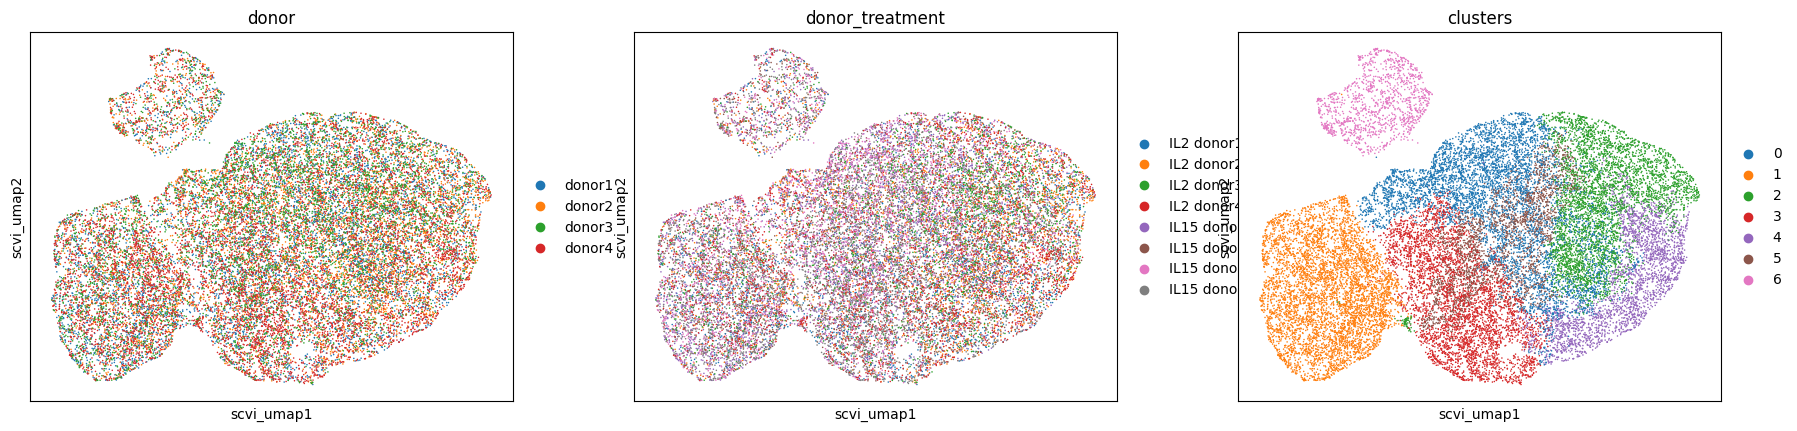

In [ ]:
sc.pl.embedding(
    adata,
    basis="scvi_umap",
    color=["donor", "donor_treatment", "clusters"],
)